## Notebook for Figure 5

In [1]:
%matplotlib inline

import requests
import os
from tqdm.notebook import tqdm

import xarray as xr
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

from one_pass import __version__ as one_pass_version
from one_pass.opa import Opa
from utils import read_or_download_dataset

from crick import TDigest

print(f"One_Pass version: {one_pass_version}")

One_Pass version: 0.8.0


Loading august half-hourly precipitation data from the ICON model, file avaliable on Zenodo

In [2]:
# Download data if not present
url = "https://zenodo.org/records/12533197/files/pr_aug_2021_ICON_ngc2009_cycle3_r100.nc?download=1"
filename = "pr_2021.nc"

ds = read_or_download_dataset(filename, url)
ds

Reading: data/pr_2021.nc


<xarray.Dataset> Size: 771MB
Dimensions:  (time: 1488, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    pr       (time, lat, lon) float64 771MB 4.098e-06 4.14e-06 ... 1.779e-05

In [3]:
ds.time

<xarray.DataArray 'time' (time: 1488)> Size: 12kB
array(['2021-08-01T00:00:00.000000000', '2021-08-01T00:30:00.000000000',
       '2021-08-01T01:00:00.000000000', ..., '2021-08-31T22:30:00.000000000',
       '2021-08-31T23:00:00.000000000', '2021-08-31T23:30:00.000000000'],
      shape=(1488,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
Attributes:
    axis:           T
    standard_name:  time

In [4]:
ds.pr

<xarray.DataArray 'pr' (time: 1488, lat: 180, lon: 360)> Size: 771MB
array([[[4.09786669e-06, 4.14017873e-06, 4.14954893e-06, ...,
         3.93221141e-06, 3.98303516e-06, 4.04278275e-06],
        [4.88669965e-06, 4.66315264e-06, 4.56163447e-06, ...,
         6.18618545e-06, 5.63130029e-06, 5.20305255e-06],
        [1.46504350e-05, 1.51325916e-05, 1.47525855e-05, ...,
         1.42959665e-05, 1.43042751e-05, 1.43006554e-05],
        ...,
        [1.72769016e-04, 1.77412938e-04, 1.80798441e-04, ...,
         1.43811106e-04, 1.55499027e-04, 1.65139462e-04],
        [2.14040882e-04, 2.18304602e-04, 2.21975703e-04, ...,
         1.96002844e-04, 2.02765113e-04, 2.08942930e-04],
        [6.39777510e-05, 6.56368232e-05, 6.64900298e-05, ...,
         5.87878723e-05, 6.05440495e-05, 6.21218266e-05]],

       [[3.95019856e-06, 3.84952833e-06, 3.75355289e-06, ...,
         4.20717777e-06, 4.14048806e-06, 4.05143732e-06],
        [4.39146081e-06, 4.11393105e-06, 3.96668523e-06, ...,
         6.05449239e-06, 5.34637617e-06, 4.79841322e-06],
        [1.22819745e-05, 1.17103407e-05, 1.09045103e-05, ...,
         1.15580923e-05, 1.26892569e-05, 1.27035220e-05],
...
         1.27676643e-05, 1.30010093e-05, 1.30177976e-05],
        [1.38422638e-05, 1.42517304e-05, 1.49022538e-05, ...,
         1.37587962e-05, 1.37665362e-05, 1.37056524e-05],
        [2.46336168e-05, 2.59567350e-05, 2.74274634e-05, ...,
         2.12206040e-05, 2.22400848e-05, 2.33303256e-05]],

       [[2.86021058e-06, 2.87272014e-06, 2.89998641e-06, ...,
         2.88924852e-06, 2.86402928e-06, 2.85221268e-06],
        [8.07433712e-07, 9.49928706e-07, 1.16649185e-06, ...,
         5.63615445e-07, 6.27848003e-07, 7.04656276e-07],
        [2.03432084e-06, 1.61122807e-06, 1.22875342e-06, ...,
         2.53701650e-06, 2.54278229e-06, 2.38216720e-06],
        ...,
        [1.32968786e-05, 1.33404939e-05, 1.36431967e-05, ...,
         1.39119278e-05, 1.35566122e-05, 1.33508807e-05],
        [1.59558036e-05, 1.60268033e-05, 1.60195530e-05, ...,
         1.43093981e-05, 1.51113128e-05, 1.57232150e-05],
        [1.88036146e-05, 1.97917069e-05, 2.08441008e-05, ...,
         1.58244267e-05, 1.68063066e-05, 1.77882784e-05]]],
      shape=(1488, 180, 360))
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes:
    cell_methods:                 t: mean
    long_name:                    precipitation flux
    number_of_grid_in_reference:  1
    param:                        52.1.0
    standard_name:                pr
    units:                        kg m-2 s-1
    regridded:                    1
    history:                      \n2024-03-06 12:28:11 AQUA💧: Regrid from R0...

Converting the units from precipitation flux in kg m-2 s-1 to mm day-1 (for easier interpretability)


In [5]:
# extracting data array
pr = ds.pr

density = 998 # kg/m3 
pr =  (pr / density) * 1000  * 60 * 60 * 24

Simulating a stream of data with the Opa class. This time data streaming using chunk weights of 10

In [6]:
step = 10
n = 0

# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece
c = len(pr.time)

opa_stat = Opa({
    "variable": "pr",
    "stat": "percentile",
    "stat_freq": "monthly",
    "output_freq": "monthly",
    "compression": 80,
    "time_step": 30,  # in minutes, set up for daily data
    "percentile_list": [],
    "checkpoint": False,
    "save": False,
})

# simulating the streamed data
for half_hour in tqdm(range(0, c, step)):

    incoming_data_chunk = pr.isel(time = slice(half_hour, half_hour + step))
    result = opa_stat.compute(incoming_data_chunk)


  0%|          | 0/149 [00:00<?, ?it/s]

In [7]:
result

<xarray.Dataset> Size: 52MB
Dimensions:     (time: 1, percentile: 100, lat: 180, lon: 360)
Coordinates:
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon         (lon) float64 3kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time        (time) datetime64[ns] 8B 2021-08-01
  * percentile  (percentile) float64 800B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99
Data variables:
    pr          (time, percentile, lat, lon) float64 52MB 9.205e-08 ... 15.19
Attributes:
    history:  2025-05-16 13:44:45 OPA : monthly percentile calculated using o...

In [8]:
digest_list = []
time_dim, lat_size, lon_size = np.shape(pr)
size_data_source = lat_size * lon_size
# flatten the lat lon grid
pr_flat = np.reshape(pr.values, [len(pr.time), size_data_source])

# adding the data for each grid cell to a TDigest object
for g in tqdm(range(size_data_source)):
    digest = TDigest(compression=80)
    digest.update(pr_flat[:, g])
    digest_list.append(digest)

  0%|          | 0/64800 [00:00<?, ?it/s]

We are now interested in extreme rainfall so we compare the estimation of the 99th percentile from the TDigest and NumPy.

We start with estimating the 99th percentile using NumPy

In [9]:
# interested in extreme rainfall so examining the 99th percentile
quantiles = 99
# empty array that will story all the NumPy percentile estimates for every grid cell
percen_np = np.zeros((1, size_data_source))
# flattening the array over the spatial grid
pr_flat = np.reshape(pr.values, [len(pr.time), size_data_source])

# going through every quantile 
percen_np[0, :] = np.percentile(pr_flat, axis = 0, q = quantiles, method = 'linear')

We now calculate the 99th percentile estimate using the t-digest and calculate the error.

In [10]:
epsilon = 1 # small parameter, see paper

# saving both the absolute error and the error a a percentage of the NumPy value
total_99per_error = np.zeros((1, size_data_source))
total_99_error = np.zeros((1, size_data_source))

large_error = []

# looping through the flattened grid
for i, digest in tqdm(enumerate(digest_list), total=len(digest_list)):

     #extracting the 99th percentile estimate for the t-digest for every grid cell
     quant_res = digest.quantile(quantiles / 100)

     # due to errors extremely close to 0 it is possible for the percentile error to be larger than
     # 100 %. We stabilise the calcluation with the small constant epsilon. See paper for details.
     error = abs(quant_res - percen_np[0, i])
     error_per = (abs(quant_res -  percen_np[0, i]) /((percen_np[0, i]) + epsilon)) *100
     
     # if percentage error is still greater than 100, set to 0 for plotting
     if error_per > 100:
          total_99per_error[0, i] = 0
          total_99_error[0, i] = 0
          large_error.append(pr_flat[:, i])
     else:
          total_99per_error[0, i] = error_per
          total_99_error[0, i] = error

print('number of error values set to 0 error is:', len(large_error))

# reshape array back to lat lon
total_99per_error = np.reshape(total_99per_error, [1, len(pr.lat), len(pr.lon)])
total_99_error = np.reshape(total_99_error, [1, len(pr.lat), len(pr.lon)])

  0%|          | 0/64800 [00:00<?, ?it/s]

number of error values set to 0 error is: 1


We want to examine a range of different errors from the NumPy to TDigest comparision. We start by examining the location with the largest mean rainfall over the month

In [11]:
mean_pr = np.mean(pr, axis = 0)
max_index = np.argmax(mean_pr.values)
max_row, max_col = np.unravel_index(max_index, mean_pr.shape)

We also want to examine the locations with the largest error. Here we find the location of the largest percentile error (based on the digests with a compression factor of 80), which corresponds to a location in Brazil

In [12]:
worst_index = np.argmax(total_99per_error)
worst_per_row, worst_per_col = np.unravel_index(worst_index, mean_pr.shape)
print('Worst percentage error:', total_99per_error[0, worst_per_row, worst_per_col], '%')

Worst percentage error: 89.75848528407265 %


We now take a bad aboslute error (the 45th), others can be examined.

In [13]:
sorted = np.sort(np.reshape(total_99_error, [1, size_data_source]))
a, bad_abs_row, bad_abs_col = np.where(total_99_error == sorted[0,-45])
bad_abs_col = bad_abs_col[0]
bad_abs_row = bad_abs_row[0]

print('Bad absolute error:', total_99_error[0, bad_abs_row, bad_abs_col], 'mm day-1')

Bad absolute error: 19.735647105405235 mm day-1


Selecting four time series to examine based on the mean monthly rainfall, maximum percentage error, a bad (but not the worst) absolute error and a random location

In [14]:
# largest percentage error - Brazil
# lat: 13.5 S, lon: 60.0 W
x1 = worst_per_col
y1 = worst_per_row
brazil_tp = pr[:, y1, x1]

# mean annual rainfall - colombia
# lat: 4.5 N, lon: 78.0 W
x2 = max_col
y2 = max_row
colombia_tp = pr[:, y2, x2]

# bad absolute error - pacific ocean
# lat: 25.5 N, lon: 142 E
x3 = bad_abs_col
y3 = bad_abs_row
pacific_tp = pr[:, y3, x3]

# random - new_york
# lat: 40.5 N, lon: 75 W
x4 = 285
y4 = 130
usa_tp = pr[:, y4, x4]

Adding these 4 specific locations to TDigest objects. 

We want to see the impact of compression factor on how well these errors are represented.

Here we set the streaming chunk weight (w) to 1 (a change from 10 above). All of the weight chunks can be changed and the same result will be obtained.

In [15]:
compression_spacing = 2
max_comp = 140
min_comp = 20

spacing = int((max_comp - min_comp)/compression_spacing)+1
compressions = np.linspace(min_comp, max_comp, spacing)
num_compressions = len(compressions)

digest_list_b = []
digest_list_c = []
digest_list_p = []
digest_list_u = []

# creating a list of TDigest objects for each location over a range of compression factors
for i in tqdm(range(num_compressions)): 
    digest_list_b.append(TDigest(compression = compressions[i]))
    digest_list_c.append(TDigest(compression = compressions[i]))
    digest_list_p.append(TDigest(compression = compressions[i]))
    digest_list_u.append(TDigest(compression = compressions[i]))

    # adding the data in streaming mode
    for j in range(len(brazil_tp)):
        digest_list_b[i].update(brazil_tp[j])
        digest_list_c[i].update(colombia_tp[j])
        digest_list_p[i].update(pacific_tp[j])
        digest_list_u[i].update(usa_tp[j])

  0%|          | 0/61 [00:00<?, ?it/s]

We then do the same analysis as with Figure 4 and calculate the t-digest error for all the different compression factors compared to the NumPy estimate, also examining the result if different NumPy interpolation schemes are used.

In [16]:
full_data_tuple = (brazil_tp, colombia_tp, pacific_tp, usa_tp)
digest_list_tuple = (digest_list_b, digest_list_c, digest_list_p, digest_list_u)

methods = (
    'inverted_cdf',
    'averaged_inverted_cdf',
    'closest_observation',
    'interpolated_inverted_cdf',
    'hazen',
    'weibull',
    'normal_unbiased',
    'linear',
)
num_methods = len(methods)

digests_99p = np.zeros((4, num_compressions))
centroid_num = np.zeros((4, num_compressions))

errors = np.zeros((4, num_compressions))
errors_p = np.zeros((4, num_compressions))
errors_bars = np.zeros((8, num_compressions))
errors_bars_p = np.zeros((8, num_compressions))

percen_np = np.zeros((4, num_methods))

quantiles = 99

# calculating the 99th percentile estimate for each compression along with corresponding number of centroids
for i, digest_list in enumerate(digest_list_tuple):
    for c in range(num_compressions):
        digests_99p[i, c] = digest_list[c].quantile(quantiles/100)
        centroid_num[i] = np.size(digest_list[c].centroids())

for i, full_data in enumerate(full_data_tuple):
    for m, method in enumerate(methods):
        # calculating the numpy percentile estimate using the avaliable interpolation schemes
        percen_np[i, m] = np.percentile(full_data, q = quantiles, method=method)

for i, full_data in enumerate(full_data_tuple):
    # calcuating the absolute and percentage errors along with error bars based on the different
    # NumPy interpolation methods for calculating percentiles

    errors[i, :] = (digests_99p[i, :] - percen_np[i, 7])
    errors_p[i, :] = errors[i, :] / (percen_np[i, 7] + epsilon) * 100

    for c in range(num_compressions):

        # Absolute error (upper and lower)
        errors_bars[2 * i + 1, c] = np.max(digests_99p[i, c] - percen_np[i, :]) - errors[i, c]
        
        errors_bars[    2 * i, c] = errors[i, c] - np.min(digests_99p[i, c] - percen_np[i, :])

        # Percentile error (upper and lower)
        errors_bars_p[2 * i + 1, c] = (
            (np.max((digests_99p[i, c] - percen_np[i, :]) / (percen_np[i, :] + epsilon)))  
            - errors[i, c] / (percen_np[i, 7] + epsilon)
        ) * 100
        
        errors_bars_p[    2 * i, c] = (
            (errors[i, c] / (percen_np[i, 7] + epsilon))
            - np.min((digests_99p[i, c] - percen_np[i, :]) / (percen_np[i, :] + epsilon))
        ) * 100

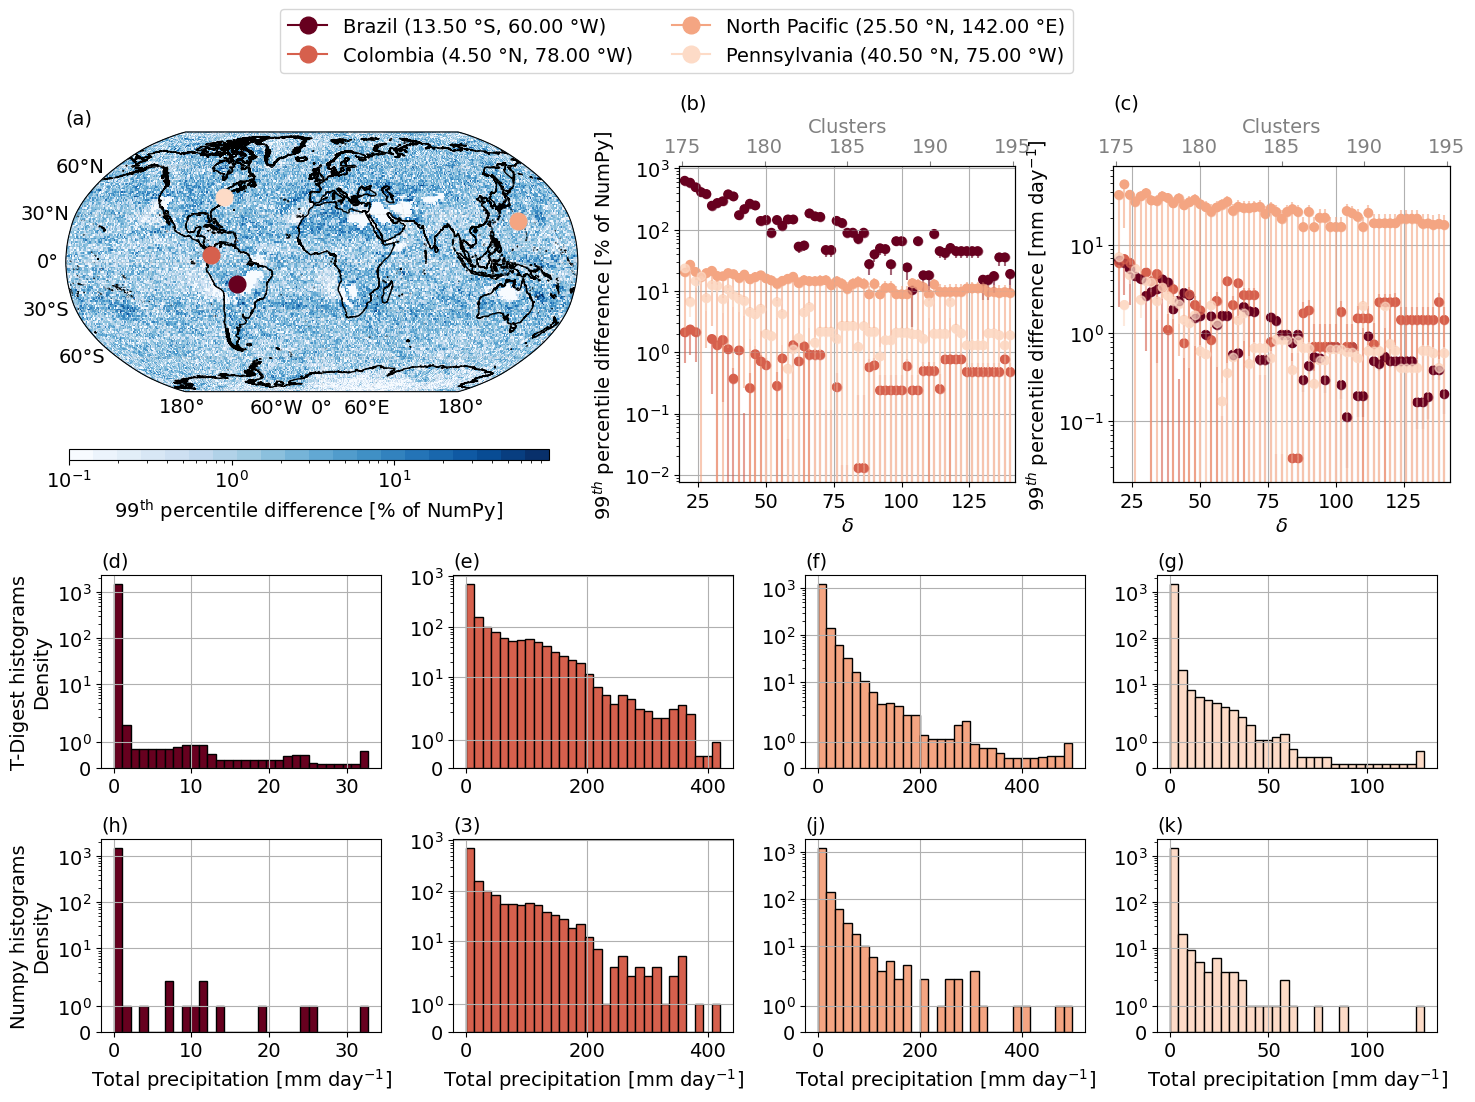

In [17]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(16,11))
fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.9, wspace = 0.2, hspace = 0.25)
nrow = 2
ncol = 3

outer = gs.GridSpec(nrow,ncol,wspace=0.3,hspace=0.12, width_ratios=[0.7, 0.7, 0.7])

square_size = 20
fsize = 14 # fontsize

colors = (
    '#67001f',
    '#d6604d',
    '#f4a582',
    '#fddbc7',
)

ax = fig.add_axes([0.018, 0.64, 0.32, 0.32], projection = robinson)  # [left, bottom, width, height]

#fig.subplots_adjust(bottom=0.05, top=0.99, left=0.01, right=0.9, wspace = 0.2, hspace = 0.4)
ax.coastlines(resolution = '10m')
 #Draw meridians and parallels
gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize}
gl.ylabel_style = {'size': fsize}

cmap = plt.get_cmap('Blues', 20)
lon2d,lat2d = np.meshgrid(pr.lon, pr.lat)

cs = ax.pcolormesh(lon2d, lat2d, total_99per_error[0,:,:], transform=ccrs.PlateCarree(),
                   cmap=cmap, norm = LogNorm(vmin = 0.1))

lon1 = pr.lon[x1].values
lat1 = pr.lat[y1].values

lon2 = pr.lon[x2].values
lat2 = pr.lat[y2].values

lon3 = pr.lon[x3].values
lat3 = pr.lat[y3].values

lon4 = pr.lon[x4].values
lat4 = pr.lat[y4].values

#Transform the coordinates of the rectangles to the projection coordinates
rect1 = robinson.transform_point(lon1, lat1, geodetic)
rect2 = robinson.transform_point(lon2, lat2, geodetic)
rect3 = robinson.transform_point(lon3, lat3, geodetic)
rect4 = robinson.transform_point(lon4, lat4, geodetic)

ax.plot(rect1[0], rect1[1], color=colors[0], marker='o', markersize=12,
        transform=robinson,  label = 'Brazil (13.50 °S, 60.00 °W)')

ax.plot(rect2[0], rect2[1], color=colors[1], marker='o', markersize=12,
    transform=robinson, label = 'Colombia (4.50 °N, 78.00 °W)')

ax.plot(rect3[0], rect3[1], color=colors[2], marker='o', markersize=12,
    transform=robinson, label = 'North Pacific (25.50 °N, 142.00 °E)')

ax.plot(rect4[0], rect4[1], color=colors[3], marker='o', markersize=12,
    transform=robinson, label = 'Pennsylvania (40.50 °N, 75.00 °W)')

ax.set_title('(a)', fontsize = fsize, loc = 'left')

cbar_ax = fig.add_axes([0.02, 0.62, 0.3, 0.01])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')  

ax.legend(loc = 'upper left', bbox_to_anchor=(0.4, 1.51), fontsize = fsize, ncol = 2)

cbar.set_label(r"99$^{\text{th}}$ percentile difference [$\%$ of NumPy]", rotation=0, fontsize = fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.update_ticks()

# making the absolute error plot
alpha = 0.6

ax = plt.subplot(outer[1])

ax.errorbar(compressions, errors_p[0, :], yerr = errors_bars_p[0:2, :], 
            marker = 'o', color=colors[0],linestyle='', alpha=alpha)
ax.errorbar(compressions, errors_p[1, :], yerr = errors_bars_p[2:4, :], 
            marker = 'o', color=colors[1],linestyle='', alpha=alpha)
ax.errorbar(compressions, errors_p[2, :], yerr = errors_bars_p[4:6, :], 
            marker = 'o', color=colors[2],linestyle='', alpha=alpha)
ax.errorbar(compressions, errors_p[3, :], yerr = errors_bars_p[6:8, :], 
            marker = 'o', color=colors[3],linestyle='', alpha=alpha)

ax.scatter(compressions, errors_p[0, :], marker = 'o', color=colors[0],linestyle='')
ax.scatter(compressions, errors_p[1, :], marker = 'o', color=colors[1],linestyle='')
ax.scatter(compressions, errors_p[2, :], marker = 'o', color=colors[2],linestyle='')
ax.scatter(compressions, errors_p[3, :], marker = 'o', color=colors[3],linestyle='')
ax.set_yscale('log')
ax.set_xlim([np.min(compressions)-2, np.max(compressions)+2])
ax.set_ylabel('99$^{th}$ percentile difference [% of NumPy]', fontsize=fsize)
ax.set_xlabel(r'$\delta$', fontsize=fsize)

ax.tick_params('y', colors='black', labelsize=fsize)
ax.tick_params('x', colors='black', labelsize=fsize)
ax.grid(True)
ax.set_title('(b)', fontsize = fsize, loc = 'left')

#Create a second x-axis sharing the same x-axis
ax2 = ax.twiny()
ax2.scatter(centroid_num[3], errors[0, :], color='gray', marker = '')
ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
ax2.tick_params('x', colors='gray', labelsize = fsize)

pos = ax.get_position()
new_pos = [pos.x0+0.07, pos.y0+0.04, pos.width*0.85, pos.height*0.7] 
ax.set_position(new_pos)

# making the percentage error graph
ax = plt.subplot(outer[2])

ax.errorbar(compressions, errors[0, :], yerr = errors_bars[0:2, :], marker = 'o', color=colors[0],
            alpha = alpha, linestyle='')
ax.errorbar(compressions, errors[1, :], yerr = errors_bars[2:4, :], marker = 'o', color=colors[1],
            alpha = alpha, linestyle='')
ax.errorbar(compressions, errors[2, :], yerr = errors_bars[4:6, :], marker = 'o', color=colors[2],
            alpha = alpha, linestyle='')
ax.errorbar(compressions, errors[3, :], yerr = errors_bars[6:8, :], marker = 'o', color=colors[3],
            alpha = alpha, linestyle='')

ax.scatter(compressions, errors[0, :], marker = 'o', color=colors[0], linestyle='')
ax.scatter(compressions, errors[1, :], marker = 'o', color=colors[1], linestyle='')
ax.scatter(compressions, errors[2, :], marker = 'o', color=colors[2], linestyle='')
ax.scatter(compressions, errors[3, :], marker = 'o', color=colors[3], linestyle='')

ax.set_ylabel('99$^{th}$ percentile difference [mm day$^{-1}$]', fontsize=fsize)
ax.set_xlim([np.min(compressions)-2, np.max(compressions)+2])

ax.tick_params('y', colors='black', labelsize=fsize)
ax.tick_params('x', colors='black', labelsize=fsize)
ax.grid(True)
ax.set_yscale('log')
ax.set_xlabel(r'$\delta$', fontsize=fsize)

ax.set_title('(c)', fontsize = fsize, loc = 'left')

#Create a second x-axis sharing the same x-axis
ax2 = ax.twiny()
ax2.scatter(centroid_num[3], errors[0, :], color='gray', marker = '')
ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
ax2.tick_params('x', colors='gray', labelsize = fsize)

pos = ax.get_position()
new_pos = [pos.x0+0.02, pos.y0+0.04, pos.width*0.85, pos.height*0.7] 
ax.set_position(new_pos)

ss = 0.175 # histogram size
bins_space = 30
digest_80_index = 30 # index for digest with compression of 80

# top left (Brazil)
# Create inset axes for the histogram        
counts, bins = digest_list_b[digest_80_index].histogram(bins_space)
ax_hist = fig.add_axes([0.04, 0.34, ss, ss])
ax_hist.hist(bins[:-1], bins=bins, weights=counts, color = colors[0], edgecolor='black',
            alpha = 1) 
ax_hist.set_ylabel('T-Digest histograms\nDensity', fontsize=fsize)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(d)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])

ax_hist = fig.add_axes([0.04, 0.10, ss, ss])
ax_hist.hist(brazil_tp, bins=bins, color=colors[0], edgecolor='black', alpha = 1, log = True)
ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
ax_hist.set_ylabel('Numpy histograms\nDensity', fontsize=fsize)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(h)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])


# top right (Colombia)
counts, bins = digest_list_c[digest_80_index].histogram(bins_space)
ax_hist = fig.add_axes([0.26, 0.34, ss, ss])
ax_hist.hist(bins[:-1], bins = bins, weights = counts, color = colors[1], edgecolor='black', 
             alpha = 1, log = True)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(e)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])

ax_hist = fig.add_axes([0.26, 0.10, ss, ss])
ax_hist.hist(colombia_tp, bins = bins, color = colors[1], edgecolor='black', alpha = 1, log = True)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.grid(True)
ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
ax_hist.set_title('(3)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])


# bottom left (North Pacific)
counts, bins = digest_list_p[digest_80_index].histogram(bins_space)
ax_hist = fig.add_axes([0.48, 0.34, ss, ss])
ax_hist.hist(bins[:-1], bins=bins, weights=counts, color=colors[2], edgecolor='black', 
             alpha = 1, log = True)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(f)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])

ax_hist = fig.add_axes([0.48, 0.10, ss, ss])
ax_hist.hist(pacific_tp, bins = bins, color = colors[2], edgecolor='black', alpha = 1, log = True)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(j)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])

# bottom right (Pennsylvania - new york)
counts, bins = digest_list_u[digest_80_index].histogram(bins_space)
ax_hist = fig.add_axes([0.7, 0.34, ss, ss])
ax_hist.hist(bins[:-1], bins=bins, weights=counts, color=colors[3], edgecolor='black', 
             alpha = 1)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(g)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog', subs = [ 2, 3, 4, 5, 6, 7, 8, 9])

ax_hist = fig.add_axes([0.7, 0.10, ss, ss])
ax_hist.hist(usa_tp, bins = bins, color = colors[3], edgecolor='black', alpha = 1, log = True)
ax_hist.tick_params('y', colors='black', labelsize=fsize)
ax_hist.tick_params('x', colors='black', labelsize=fsize)
ax_hist.set_xlabel(r'Total precipitation [mm day$^{-1}$]', fontsize=fsize)
ax_hist.grid(True)
ax_hist.set_title('(k)', fontsize = fsize, loc = 'left')
ax_hist.set_yscale('symlog',base = 10, subs = [2, 3, 4, 5, 6, 7, 8, 9])


plt.show()